### Imports

In [20]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.filters


from scipy import ndimage as ndi

from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                area_closing,
                                white_tophat)
from skimage.morphology import disk

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

import cv2
plt.rcParams['figure.dpi'] = 80

### Load the image

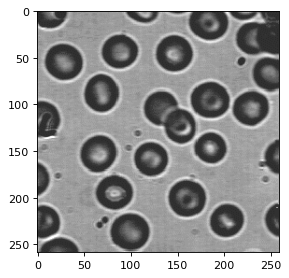

In [21]:
image = cv2.imread("../BLOODCELLS.bmp")

fig, ax = plt.subplots()
plt.imshow(image)
plt.show()

### Preprocessing

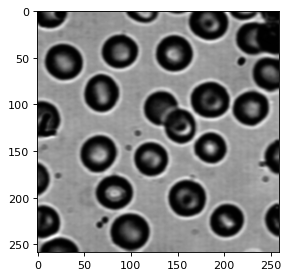

In [22]:
# convert the image to grayscale
gray_image = skimage.color.rgb2gray(image)

# blur the image to denoise
blurred_image = skimage.filters.gaussian(gray_image, sigma=1.0)

fig, ax = plt.subplots()
plt.imshow(blurred_image, cmap='gray')
plt.show()

### Histogram

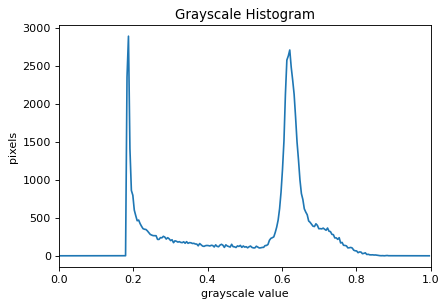

In [23]:
# create a histogram of the blurred grayscale image
histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))

plt.plot(bin_edges[0:-1], histogram)
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim(0, 1.0)
plt.show()

### Thresholding

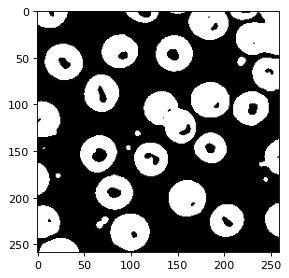

In [24]:
# create a mask based on the threshold
t = 0.5
binary_mask = blurred_image < t

fig, ax = plt.subplots()
plt.imshow(binary_mask, cmap='gray')
plt.show()

Blood cells are black on the gray background, but in the same time we see white parts inside the blood cells. Some of blood cells are touching each other. It can make our task more difficult. To work with cells as objects we have to fill them and separate from each other.

### Structuring element

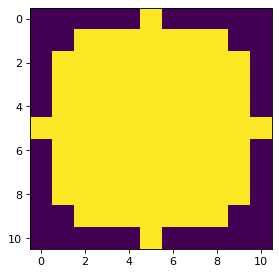

In [25]:
se = disk(5)
plt.imshow(se)
plt.show()

Disk is the obvious choice, because it tends to be circle with the increasing of size, and we deal with circular elements in our image. Also disk is time effective se. Size was choosen empirically.

### Erosion

In [26]:
plt.rcParams['figure.dpi'] = 200

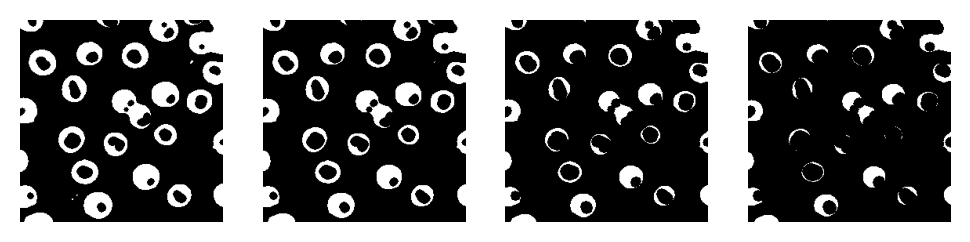

In [27]:

image = binary_mask
for i, size in enumerate([3, 4, 5, 6]):
    plt.subplot(1,4,i+1)
    image_eroded = erosion(image, disk(size))
    plt.axis('off')
    plt.imshow(image_eroded, cmap='gray')
plt.show()

We can see that with disk of size 4 we keep all the blood cells boundaries not touched except for one of two connected ones in the center of the image, in the same time there is no unneeded particles in the image. 5 separates touched cells but modify some cells boundaries. 

### Dilation

For the dilation the same shape of the structuring element is used, because of the same reasons. The size is choozen empirically 

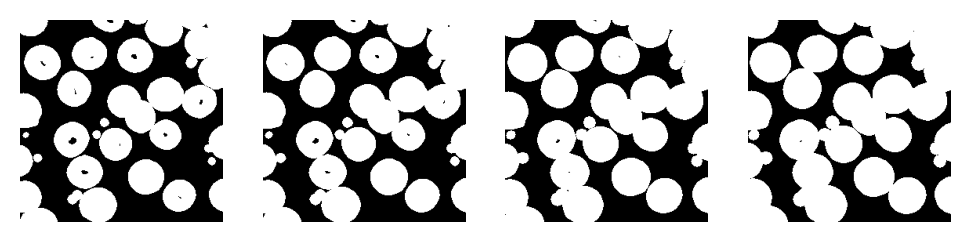

In [28]:
for i, size in enumerate([3, 4, 5, 6]):
    plt.subplot(1,4,i+1)
    image_dileted = dilation(image, disk(size))
    plt.imshow(image_dileted, cmap='gray')
    plt.axis('off')
plt.show()

### Improvements

We can try to start with dilation operation or with erosion one. It would be better to make step firstly which is not affecting the important image features. So we try the maximum possible disk size, which performs gently.

If we start with dilation to fill the holes we want to have as much filled holes as possible and don't have touched blood cells with each other or with unwanted particles. This size is 2.

If we start with erosion to remove all salt noise we want to have as much noie removed as possible and don't have corrupted cells edges. This size is also 2.


We can see that with disk of size 7 we have all holles inside cells closed, but in the same time there are a lot of cells touching each other. Lower sizes are not enough to fill all holes.

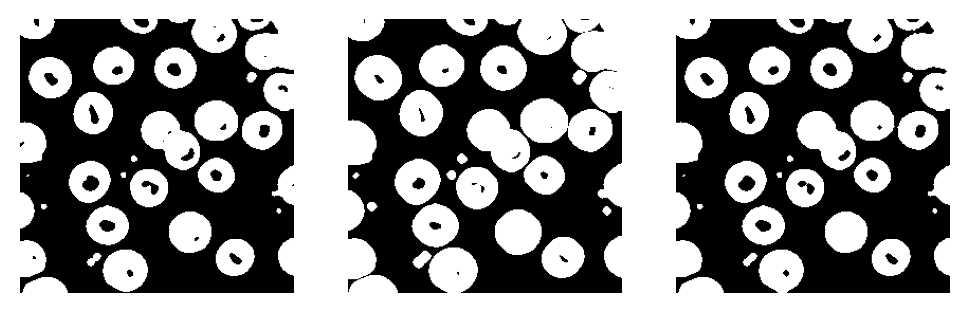

In [29]:
# Start with dilation

image_dil = dilation(image, disk(2))
image_er = erosion(image_dil, disk(2))


image_stages = [image, image_dil, image_er]

for i, im in enumerate(image_stages):
    plt.subplot(1,len(image_stages), i+1)
    plt.imshow(im, cmap='gray')
    plt.axis('off')

plt.show()

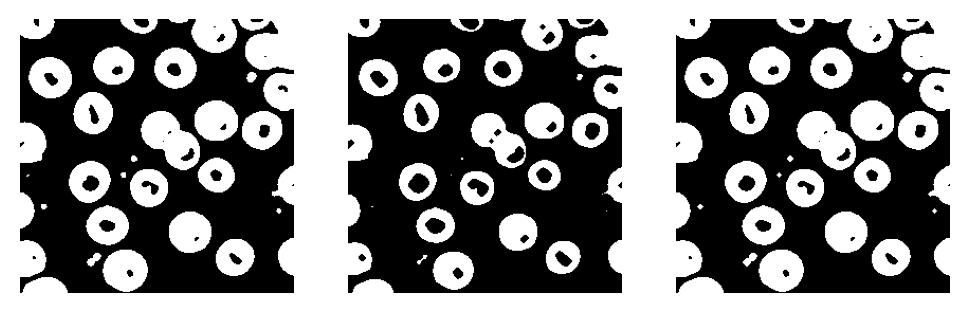

In [30]:
# Start with erosion

image_er = erosion(image, disk(2))
image_dil = dilation(image_er, disk(2))


image_stages = [image, image_er, image_dil]

for i, im in enumerate(image_stages):
    plt.subplot(1,len(image_stages), i+1)
    plt.imshow(im, cmap='gray')
    plt.axis('off')

plt.show()


For previous tries we see that proposed size is not enough then we cannot split all cells without corrapting the image, so we try to corrapte it as less as possible. 

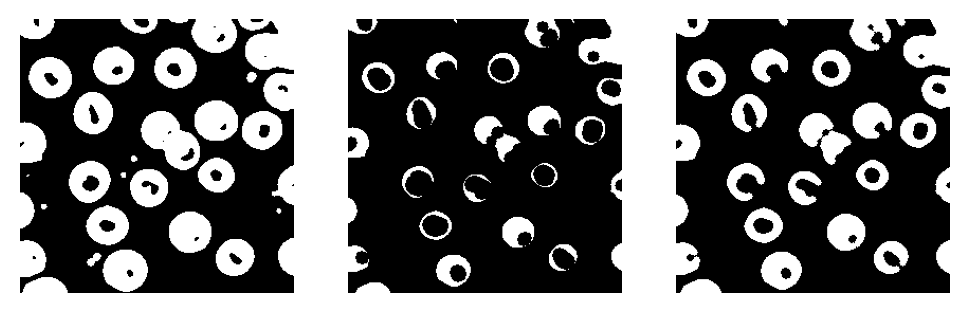

In [31]:
image_er = erosion(image, disk(5))
image_dil = dilation(image_er, disk(3))


image_stages = [image, image_er, image_dil]

for i, im in enumerate(image_stages):
    plt.subplot(1,len(image_stages), i+1)
    plt.imshow(im, cmap='gray')
    plt.axis('off')

plt.show()

The best combination of erosions and dilations is erosion with disk of size 5 then dilation with the disk of size 3 to have all blood cells separated with no unneeded particles and have as much accurate blood cells as possible. But in such case a lot of cells edges are corrupted and some of cells now are just small area of the initially. But anyway we can count and label cells easily.

### New operations and labeling

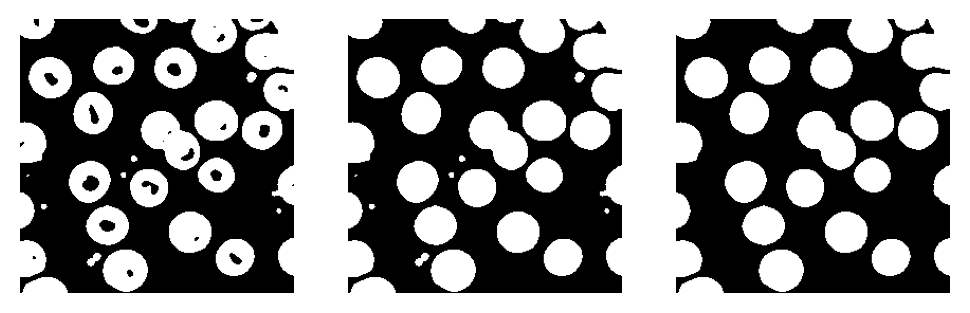

In [32]:
image_closed = area_closing(image, area_threshold=256)
image_clean = opening(image_closed, disk(5))

image_stages = [image, image_closed, image_clean] 

for i, im in enumerate(image_stages):
    plt.subplot(1,len(image_stages), i+1)
    plt.imshow(im, cmap='gray')
    plt.axis('off')
plt.show()

To remove all the redundant particles and fill all holes we utilize area_closing and oprining operations. But we still two connected blood cells in the center of the images and three conected cells in perefery.

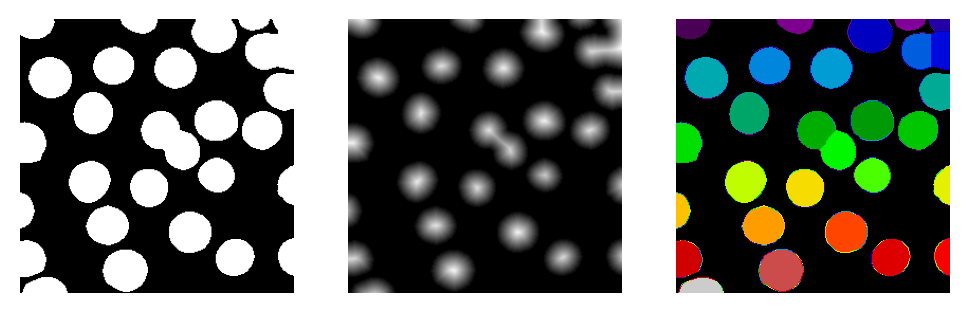

In [33]:
distance = ndi.distance_transform_edt(image_clean)
distance_ = distance.copy()
coords = peak_local_max(distance_, footprint=np.ones((15, 15)), labels=image_clean)
mask = np.zeros(distance_.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance_, markers, mask=image_clean)

image_stages = [image_clean, distance]

for i, im in enumerate(image_stages):
    plt.subplot(1,3, i+1)
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
plt.show()

We can perfectly separate connected cells by applying watershed segmentation

In [41]:
labels_list = np.unique(labels)
labels_list = labels_list[1:]
len(labels_list)

29

The number of cells is 29

In [76]:
lowest_cell_size = float('inf')
highest_cell_size = 0
lowes_cell_n = None
highest_cell_n = None
for label in labels_list:
    curr_size = np.count_nonzero([labels == label])
    if curr_size < lowest_cell_size:
        lowest_cell_size = curr_size
        lowes_cell_n = label
    elif curr_size > highest_cell_size:
        highest_cell_size = curr_size
        highest_cell_n = label
        
    print(f"Blood cell # {label:2d}  Size:{curr_size:6d} pixels")

Blood cell #  1  Size:   533 pixels
Blood cell #  2  Size:   373 pixels
Blood cell #  3  Size:   249 pixels
Blood cell #  4  Size:   218 pixels
Blood cell #  5  Size:  1143 pixels
Blood cell #  6  Size:   617 pixels
Blood cell #  7  Size:   837 pixels
Blood cell #  8  Size:  1092 pixels
Blood cell #  9  Size:  1204 pixels
Blood cell # 10  Size:  1246 pixels
Blood cell # 11  Size:   867 pixels
Blood cell # 12  Size:  1165 pixels
Blood cell # 13  Size:  1258 pixels
Blood cell # 14  Size:   985 pixels
Blood cell # 15  Size:  1098 pixels
Blood cell # 16  Size:   804 pixels
Blood cell # 17  Size:   924 pixels
Blood cell # 18  Size:   877 pixels
Blood cell # 19  Size:  1202 pixels
Blood cell # 20  Size:   435 pixels
Blood cell # 21  Size:  1033 pixels
Blood cell # 22  Size:   350 pixels
Blood cell # 23  Size:  1146 pixels
Blood cell # 24  Size:  1250 pixels
Blood cell # 25  Size:   405 pixels
Blood cell # 26  Size:  1007 pixels
Blood cell # 27  Size:   716 pixels
Blood cell # 28  Size:  1325

In [77]:
highest_cell_n, lowes_cell_n

(28, 4)

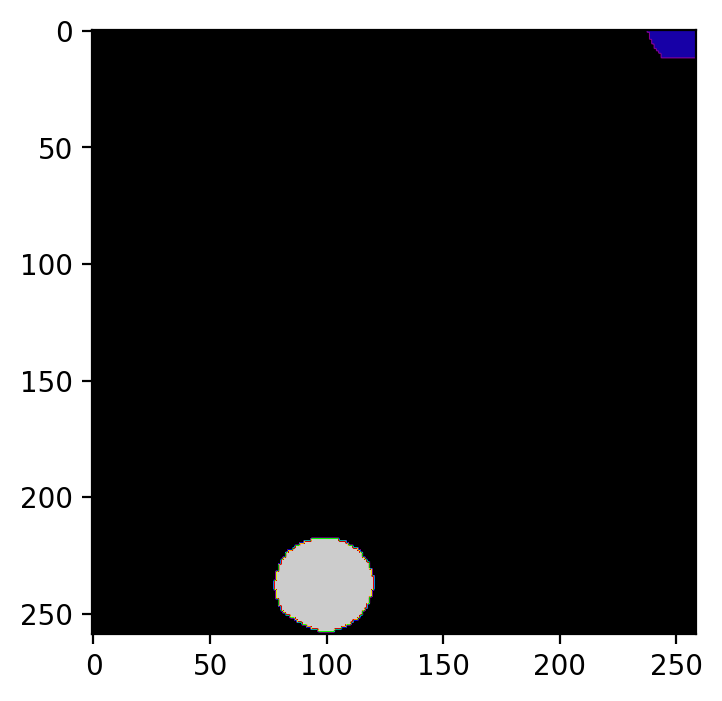

In [78]:
labels_hl = labels.copy()
labels_hl[(labels_hl != highest_cell_n) * (labels_hl != lowes_cell_n)] = 0
plt.imshow(labels_hl, cmap=plt.cm.nipy_spectral)
plt.show()